# release

In [18]:
import torch
import random
from typing import Dict, List
from functools import partial
import datasets
from transformers import (
    AutoTokenizer,
    GPT2Tokenizer,
    GPTNeoXTokenizerFast,
    LlamaTokenizer,
    OPTForCausalLM,
)
import utils
import os
import importlib

importlib.reload(utils)

<module 'utils' from '/data/users/zhangjunlei/tyx/reward-by-prm800k/src/utils.py'>

In [2]:
class MockArgs:
    raw_dataset_json_path = utils.prm800k_phase_train_jsonl_paths

    encoded_dataset_output_dirpath = utils.encoded_datasets_path
    preprocessing_num_workers = 16
    overwrite_cache = False
    model_name_or_path = "meta-llama/Llama-2-7b-hf"
    tokenizer_name = utils.tokenizer_name_or_path
    use_slow_tokenizer = True
    max_seq_length = None


args = MockArgs()

In [3]:
def pick_prm800k_samples(x):
    return (not x["is_quality_control_question"]) and (
        x["label"]["finish_reason"] in ["found_error", "solution"]
    )


def reformat_prm800k_sample(sample: dict) -> dict:
    problem = sample["question"]["problem"]
    step_ratings = []

    if sample["is_quality_control_question"]:
        raise RuntimeError("is_quality_control_question is True")

    label = sample["label"]
    finish_reason = label["finish_reason"]
    if finish_reason not in ["found_error", "solution"]:
        raise RuntimeError(f"finish_reason is {finish_reason}")

    steps = label["steps"]
    for step in steps:
        chosen_completion = step["chosen_completion"]
        if step["human_completion"] is not None:
            completion = step["human_completion"]
            rating = 1
        else:
            completions = step["completions"]
            if chosen_completion is not None:
                completion = completions[chosen_completion]
            else:
                for completion in completions:
                    if completion["rating"] == -1:
                        break
            rating = completion["rating"]

        step_text = completion["text"]

        if completion["flagged"] not in [None, False]:
            print(f"{sample['timestamp']} flagged: ", completion["flagged"])
            print(sample)
        step_ratings.append({"step": step_text, "rating": rating})

    reformatted_sample = {"problem": problem, "step_ratings": step_ratings}

    if finish_reason == "found_error":
        last_rating = reformatted_sample["step_ratings"][-1]["rating"]
        assert last_rating == -1, f"last step should be -1 but {last_rating}"

    return reformatted_sample


def encode_with_problem_step_ratings_format(
    reformatted_sample, tokenizer, split="train", test=False
):
    """
    Here we assume each sample has a 'step_ratings' field. Each step_rating is a dict.
    """

    step_ratings = reformatted_sample["step_ratings"]
    if len(step_ratings) == 0:
        raise ValueError("step_ratings field is empty.")

    rating2word = {1: "positive", -1: "negative", 0: "neutral"}
    rating2token_id = {
        rating: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word))[0]
        for rating, word in rating2word.items()
    }

    problem = reformatted_sample["problem"].strip()
    problem_step_ratings_text = problem + "\n"
    sample_input_ids = tokenizer(
        problem + "\n",
        return_tensors="pt",
        padding=False,
        truncation=False,
        add_special_tokens=True,
        return_attention_mask=False,
    )["input_ids"]
    ignore_index = -100

    if split == "train":
        sample_labels = torch.ones_like(sample_input_ids) * ignore_index
    elif split == "validation":
        sample_labels = []
    else:
        raise ValueError(f"split should be train or validation but {split}")

    for step_rating in step_ratings:
        step = step_rating["step"].strip()

        problem_step_ratings_text += step + "\n"

        step_input_ids = tokenizer(
            "\n" + step + "\n",
            return_tensors="pt",
            padding=False,
            truncation=False,
            # add_special_tokens=True,
            add_special_tokens=False,
            return_attention_mask=False,
        )["input_ids"]
        step_input_ids = step_input_ids[:, 2:]  # remove "\n"
        sample_input_ids = torch.cat((sample_input_ids, step_input_ids), dim=1)

        step_rating_token_id = rating2token_id[step_rating["rating"]]
        if split == "train":
            step_labels = torch.ones_like(step_input_ids) * ignore_index
            step_labels[
                :, -1
            ] = step_rating_token_id  # set the label for the last token_id before "\n"
            sample_labels = torch.cat((sample_labels, step_labels), dim=1)
            # keep the last token for hugging face to align input_ids and labels
        elif split == "validation":
            sample_labels.append(step_rating_token_id)
        else:
            raise ValueError(f"split should be train or validation but {split}")

    if split == "validation":
        sample_labels = torch.tensor(sample_labels)

    if test:
        sample_input_ids_from_simple_call = tokenizer(
            problem_step_ratings_text,
            return_tensors="pt",
            padding=False,
            truncation=False,
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
        assert torch.equal(sample_input_ids, sample_input_ids_from_simple_call), (
            sample_input_ids != sample_input_ids_from_simple_call
        )

    # attention_mask = torch.ones_like(sample_input_ids)
    encoded_sample = {
        "input_ids": sample_input_ids.flatten(),
        "labels": sample_labels.flatten(),
        # "attention_mask": attention_mask.flatten(),
    }
    return encoded_sample

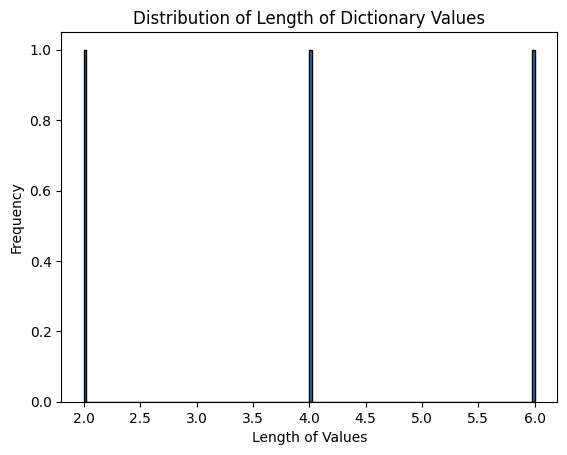

In [4]:
import matplotlib.pyplot as plt


def visualize_dict_values_length(data_dict):
    # Get the lengths of values in the dictionary
    value_lengths = [len(value) for value in data_dict.values()]

    # Create a histogram to visualize the distribution
    plt.hist(value_lengths, bins=200, edgecolor="k")

    # Add labels and title
    plt.xlabel("Length of Values")
    plt.ylabel("Frequency")
    plt.title("Distribution of Length of Dictionary Values")

    # Show the plot
    plt.show()


# Example usage:
data_dict = {"key1": [1, 2, 3, 4], "key2": [1, 2, 3, 4, 5, 6], "key3": [1, 2]}

visualize_dict_values_length(data_dict)

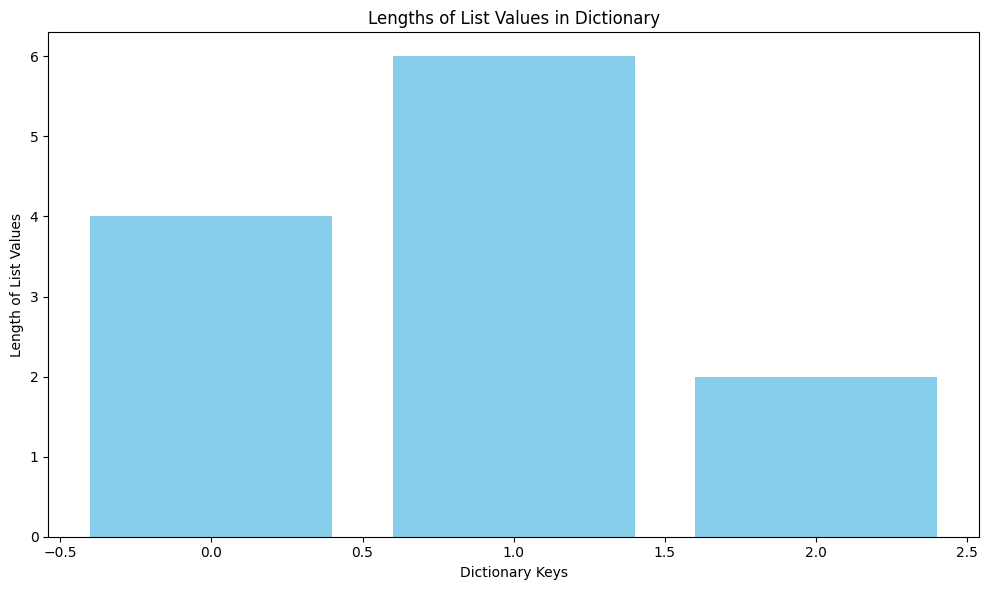

In [5]:
import matplotlib.pyplot as plt


def visualize_dict_values_lengths(data_dict):
    # Extract the lengths of values in the dictionary
    value_lengths = [len(value) for value in data_dict.values()]

    # Extract the keys (corresponding to dictionary items)
    # short_keys = [key[: min(10, len(value_lengths))] for key in data_dict.keys()]
    keys = list(range(len(data_dict)))

    # Create a bar plot
    plt.figure(figsize=(10, 6))  # Optional: adjust figure size
    plt.bar(keys, value_lengths, color="skyblue")

    # Add labels and title
    plt.xlabel("Dictionary Keys")
    plt.ylabel("Length of List Values")
    plt.title("Lengths of List Values in Dictionary")

    # Rotate x-axis labels for better readability (optional)
    # plt.xticks(rotation=45, ha="right")

    # Show the plot
    plt.tight_layout()  # Optional: adjust layout for better display
    plt.show()


# Example usage:
data_dict = {"key1": [1, 2, 3, 4], "key2": [1, 2, 3, 4, 5, 6], "key3": [1, 2]}

visualize_dict_values_lengths(data_dict)

In [6]:
# main()
dataset_args = {
    # "streaming": True,
}

reformat_col_names = ["problem", "step_ratings"]
train_data_files_list = args.raw_dataset_json_path
reformatted_prm800k_phase_train_list = [None] * len(train_data_files_list)
for idx, data_files_train in enumerate(train_data_files_list):
    prm800k_phase_train = datasets.load_dataset(
        "json",
        data_files={"train": data_files_train},
        split="train",
    )
    filtered_prm800k_phase_train = prm800k_phase_train.filter(pick_prm800k_samples)
    reformatted_filtered_prm800k_phase_train = filtered_prm800k_phase_train.map(
        reformat_prm800k_sample,
        batched=False,
        num_proc=args.preprocessing_num_workers,
        load_from_cache_file=not args.overwrite_cache,
        remove_columns=[
            name
            for name in filtered_prm800k_phase_train.column_names
            if name not in reformat_col_names
        ],
        desc="Reformatting(extractting) SFT data",
    )
    reformatted_prm800k_phase_train_list[idx] = reformatted_filtered_prm800k_phase_train
full_dataset = datasets.concatenate_datasets(reformatted_prm800k_phase_train_list)

In [7]:
print(full_dataset)
solutions_key_by_problem = utils.key_by_problem(full_dataset)

Dataset({
    features: ['problem', 'step_ratings'],
    num_rows: 87012
})


10821


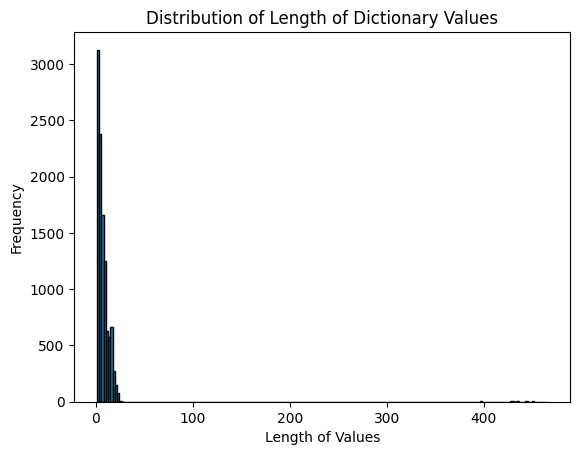

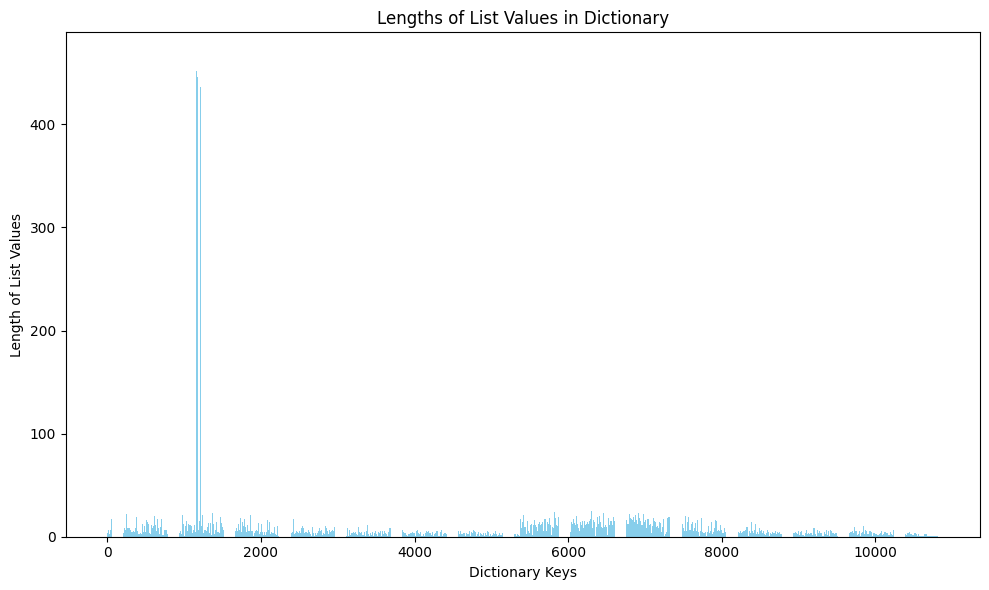

In [8]:
print(len(solutions_key_by_problem))
visualize_dict_values_length(solutions_key_by_problem)
visualize_dict_values_lengths(solutions_key_by_problem)

/tmp/ipykernel_2572043/1834196977.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  validation_solutions_key_by_problem = random.sample(


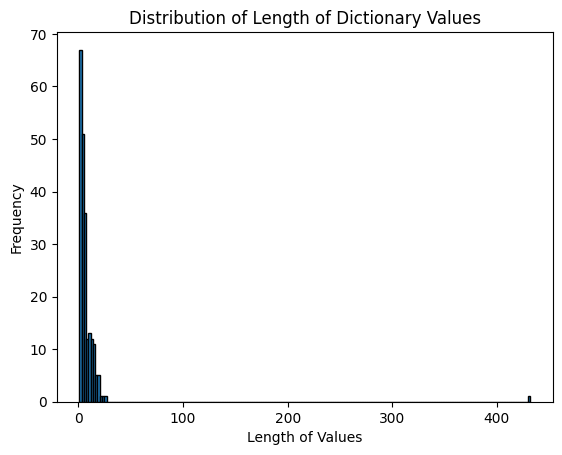

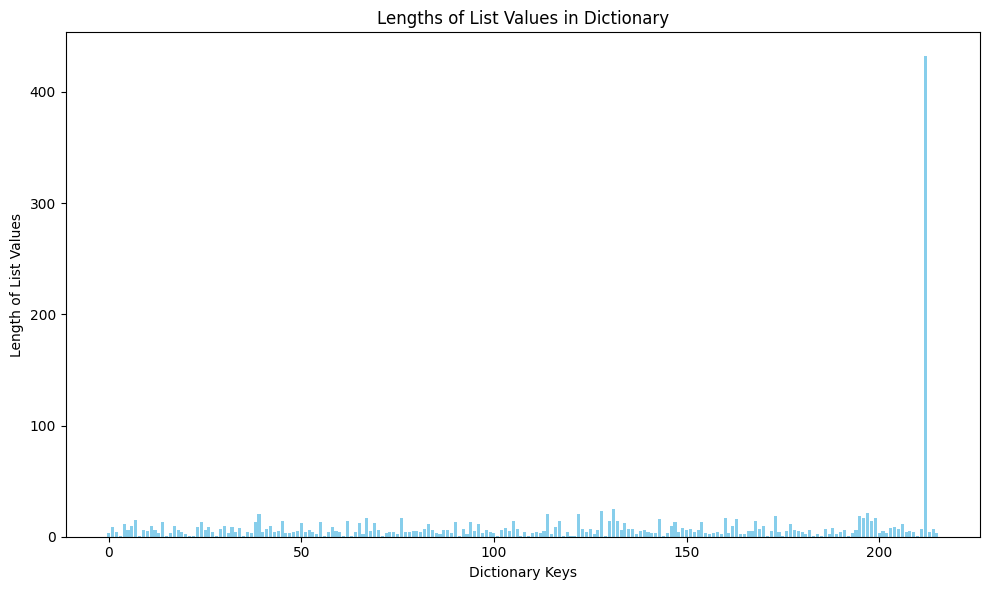

In [9]:
random.seed(42)
validation_solutions_key_by_problem = random.sample(
    solutions_key_by_problem.items(), int(0.02 * len(solutions_key_by_problem))
)
validation_solutions_key_by_problem = dict(validation_solutions_key_by_problem)

visualize_dict_values_length(validation_solutions_key_by_problem)
visualize_dict_values_lengths(validation_solutions_key_by_problem)

In [10]:
train_solutions = {feature: [] for feature in full_dataset.features}
validation_solutions = {feature: [] for feature in full_dataset.features}
for sample in full_dataset:
    problem = sample["problem"]
    step_ratings = sample["step_ratings"]
    if problem in validation_solutions_key_by_problem.keys():
        validation_solutions["problem"].append(problem)
        validation_solutions["step_ratings"].append(step_ratings)
    else:
        train_solutions["problem"].append(problem)
        train_solutions["step_ratings"].append(step_ratings)

In [11]:
train_dataset = datasets.Dataset.from_dict(
    train_solutions, features=full_dataset.features, split="train"
)
validation_dataset = datasets.Dataset.from_dict(
    validation_solutions, features=full_dataset.features, split="validation"
)

In [12]:
print(train_dataset)
print(validation_dataset)

Dataset({
    features: ['problem', 'step_ratings'],
    num_rows: 85194
})
Dataset({
    features: ['problem', 'step_ratings'],
    num_rows: 1818
})


In [13]:
raw_datasets = datasets.DatasetDict(
    {"train": train_dataset, "validation": validation_dataset}
)
print(raw_datasets)
print(raw_datasets.column_names)

DatasetDict({
    train: Dataset({
        features: ['problem', 'step_ratings'],
        num_rows: 85194
    })
    validation: Dataset({
        features: ['problem', 'step_ratings'],
        num_rows: 1818
    })
})
{'train': ['problem', 'step_ratings'], 'validation': ['problem', 'step_ratings']}


In [15]:
print(raw_datasets["train"][0])

{'problem': 'How many seconds are in 7.8 minutes?', 'step_ratings': [{'rating': 1, 'step': '7.8 minutes is the same as 7 minutes and 0.8 minutes.'}, {'rating': 1, 'step': 'Right, and since there are 60 seconds in a minute, then there are 60 * 7 = 420 seconds in 7 minutes.'}, {'rating': 1, 'step': 'And since there are 60 seconds in a minute, then there are 60 * 0.8 = 48 seconds in 0.8 minutes.'}, {'rating': 1, 'step': 'So, in total, there are 420 + 48 = 468 seconds in 7.8 minutes.'}, {'rating': 1, 'step': 'Exactly.\n\n# Answer\n\n468'}]}


In [ ]:
raw_datasets.save_to_disk(utils.raw_datasets_path)

In [59]:
# import os

# os.environ["TRANSFORMERS_OFFLINE"] = "1"

model = None

tokenizer = utils.get_complete_tokenizer()

LlamaTokenizerFast(name_or_path='/data/users/zhangjunlei/tyx/.cache/huggingface/hub/models--hf-internal-testing--llama-tokenizer/snapshots/99eceeba6e8289bee767f0771166b5917e70e470', vocab_size=32000, model_max_length=4096, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False)


In [60]:
encode_fn = partial(
    encode_with_problem_step_ratings_format,
    tokenizer=tokenizer,
    # max_seq_length=args.max_seq_length,
)

# train_encode_fn = partial(encode_fn, split="train")
# validation_encode_fn = partial(encode_fn, split="validation")

encoded_feature_names = [
    "input_ids",
    "labels",
]  # ["input_ids", "labels", "attention_mask"]

# train_dataset = train_dataset.map(
#     train_encode_fn,
#     batched=False,
#     num_proc=args.preprocessing_num_workers,
#     load_from_cache_file=not args.overwrite_cache,
#     remove_columns=[
#         name
#         for name in raw_datasets["train"].column_names
#         if name not in encoded_feature_names
#     ],
#     desc="Encoding text-classfication by CausalLM train data",
# )

# validation_dataset = validation_dataset.map(
#     validation_encode_fn,
#     batched=False,
#     num_proc=args.preprocessing_num_workers,
#     load_from_cache_file=not args.overwrite_cache,
#     remove_columns=[
#         name
#         for name in raw_datasets["train"].column_names
#         if name not in encoded_feature_names
#     ],
#     desc="Encoding text-classfication by CausalLM validation data",
# )

lm_datasets = raw_datasets.map(
    encode_fn,
    batched=False,
    # batched=True,
    num_proc=args.preprocessing_num_workers,
    load_from_cache_file=not args.overwrite_cache,
    remove_columns=[
        name
        for name in raw_datasets["train"].column_names
        if name not in encoded_feature_names
    ],
    desc="Encoding data for text-classfication by CausalLM",
)

Encoding data for text-classfication by CausalLM (num_proc=16):   0%|          | 0/85194 [00:00<?, ? examples/…

Encoding data for text-classfication by CausalLM (num_proc=16):   0%|          | 0/1818 [00:00<?, ? examples/s…

In [62]:
lm_datasets.set_format(type="pt")
lm_datasets = lm_datasets.filter(lambda example: (example["labels"] != -100).any())

Filter:   0%|          | 0/85194 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1818 [00:00<?, ? examples/s]

In [63]:
print(lm_datasets)

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 85194
    })
    validation: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 1818
    })
})


In [66]:
lm_datasets.save_to_disk(args.encoded_dataset_output_dirpath)

Saving the dataset (0/1 shards):   0%|          | 0/85194 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1818 [00:00<?, ? examples/s]

# test

In [155]:
print(raw_datasets["train"][random.randint(0, len(raw_datasets["train"]))])

{'problem': 'If $a$ and $b$ are positive integers for which $ab - 6a + 5b = 373$, what is the minimal possible value of $|a - b|$?', 'step_ratings': [{'rating': -1, 'step': 'The first thing I notice is that the equation is symmetric in $a$ and $b$, meaning that if I swap $a$ and $b$, the equation stays the same.'}]}


In [156]:
print(len(full_dataset))  # 87012
print(full_dataset[random.randint(0, len(full_dataset))])

87012
{'input_ids': tensor([    1,  1724,   338,   278, 14176,  3619,  8572,   272,   310, 29871,
        29896, 29946, 29900, 29955,   322, 29871, 29929, 29900, 29941, 29973,
           13,  1762,  1284,   278, 14176,  3619,  8572,   272,   313, 29954,
         6530, 29897,   310,  1023,  3694, 29892,   306,   817,   304,  1284,
          278, 10150,  6374,  6043,   393,  1933,  2247,  1716,  3694,  1584,
          368, 29889,    13,  6716,   982,   304,   437,   445,   338,   304,
          671,   278,   382, 27511,  5687, 29892,   607,  4083,   393,   278,
          402,  6530,   310,  1023,  3694,   263,   322,   289,   338,   278,
         1021,   408,   278,   402,  6530,   310,   289,   322,   278, 21162,
          310,   263, 13931,   491,   289, 29889,    13,  6295, 29892,   306,
        29915,   645,  1369,   491,  1933,  4821, 29871, 29896, 29946, 29900,
        29955,   491, 29871, 29929, 29900, 29941,   322,  9138,   278, 21162,
        29889,    13, 15156,  1472,  8542, 2

# debug

In [ ]:
# raw_dataset_sample = raw_dataset[random.randint(0, len(raw_dataset))]
# print(raw_dataset_sample)
raw_dataset_example = {
    "labeler": "68e6d5f3-747c-4420-97b4-a30a73f639f9",
    "timestamp": "2022-11-01T17:20:23.427734",
    "generation": 4,
    "is_quality_control_question": False,
    "is_initial_screening_question": False,
    "question": {
        "problem": "If the system of equations\n\n\\begin{align*}\n6x-4y&=a,\\\\\n6y-9x &=b.\n\\end{align*}has a solution $(x, y)$ where $x$ and $y$ are both nonzero, find $\\frac{a}{b},$ assuming $b$ is nonzero.",
        "ground_truth_solution": "If we multiply the first equation by $-\\frac{3}{2}$, we obtain\n\n$$6y-9x=-\\frac{3}{2}a.$$Since we also know that $6y-9x=b$, we have\n\n$$-\\frac{3}{2}a=b\\Rightarrow\\frac{a}{b}=\\boxed{-\\frac{2}{3}}.$$",
        "ground_truth_answer": "-\\frac{2}{3}",
        "pre_generated_steps": [
            "I notice that the coefficients of the system are multiples of 3, so I can divide both equations by 3 to simplify them.",
            "\\begin{align*}\n2x-\\frac{4}{3}y&=\\frac{a}{3},\\\\\n2y-3x &=\\frac{b}{3}.\n\\end{align*}",
            "I also notice that the coefficients of $x$ and $y$ in the second equation are the negatives of the coefficients of $y$ and $x$ in the first equation, respectively.",
            "This suggests that I can add the two equations to eliminate one of the variables.",
            "\\begin{align*}\n2x-\\frac{4}{3}y+\\left(2y-3x\\right)&=\\frac{a}{3}+\\frac{b}{3},\\\\\n\\frac{2}{3}y- x &=\\frac{a+b}{3}.\n\\end{align*}",
            "Now I can solve for $y$ in terms of $x$ and the constants.",
            "\\begin{align*}\n\\frac{2}{3}y&= x + \\frac{a+b}{3},\\\\\ny&= \\frac{3}{2}x + \\frac{a+b}{2}.\n\\end{align*}",
            "I can substitute this expression for $y$ into either of the original equations to get an equation involving only $x$ and the constants.",
            "I choose the first equation for convenience.",
            "\\begin{align*}\n2x-\\frac{4}{3}\\left(\\frac{3}{2}x + \\frac{a+b}{2}\\right)&=\\frac{a}{3},\\\\\n2x-2x - \\frac{2}{3}\\left(a+b\\right)&=\\frac{a}{3},\\\\\n-\\frac{2}{3}\\left(a+b\\right)&=\\frac{a}{3},\\\\\n-2\\left(a+b\\right)&=a,\\\\\na&=-2b.\n\\end{align*}",
            "I have found a relationship between $a$ and $b$ that must hold for the system to have a nonzero solution.",
            "I can use this to find the ratio $\\frac{a}{b}$ by dividing both sides by $b$.",
            "\\begin{align*}\n\\frac{a}{b}&=\\frac{-2b}{b},\\\\\n\\frac{a}{b}&=-2.\n\\end{align*}",
            "This is the answer I was looking for.",
            "# Answer\n\n-2",
        ],
        "pre_generated_answer": "-2",
        "pre_generated_verifier_score": 0.12514245681574954,
    },
    "label": {
        "steps": [
            {
                "completions": [
                    {
                        "text": "I notice that the coefficients of the system are multiples of 3, so I can divide both equations by 3 to simplify them.",
                        "rating": 0,
                        "flagged": None,
                    }
                ],
                "human_completion": None,
                "chosen_completion": 0,
            },
            {
                "completions": [
                    {
                        "text": "\\begin{align*}\n2x-\\frac{4}{3}y&=\\frac{a}{3},\\\\\n2y-3x &=\\frac{b}{3}.\n\\end{align*}",
                        "rating": 1,
                        "flagged": None,
                    }
                ],
                "human_completion": None,
                "chosen_completion": 0,
            },
            {
                "completions": [
                    {
                        "text": "I also notice that the coefficients of $x$ and $y$ in the second equation are the negatives of the coefficients of $y$ and $x$ in the first equation, respectively.",
                        "rating": -1,
                        "flagged": None,
                    },
                    {
                        "text": "To eliminate one of the variables, I can try to make the coefficients of $x$ or $y$ match in both equations. I see that multiplying the first equation by $\\frac{3}{4}$ and the second equation by $-\\frac{4}{3}$ will achieve this for $y$.",
                        "rating": -1,
                        "flagged": False,
                    },
                    {
                        "text": "I want to eliminate one of the variables, so I multiply the first equation by $\\frac{3}{2}$ and the second equation by $x$ to get",
                        "rating": -1,
                        "flagged": False,
                    },
                    {
                        "text": "I want to find a way to eliminate one of the variables and solve for the other, so I can use the substitution or elimination method.",
                        "rating": 1,
                        "flagged": False,
                    },
                    {
                        "text": "I want to eliminate one of the variables, so I can multiply the first equation by $\\frac{3}{2}$ and add it to the second equation.",
                        "rating": -1,
                        "flagged": False,
                    },
                ],
                "human_completion": None,
                "chosen_completion": None,
            },
        ],
        "total_time": 418405,
        "finish_reason": "found_error",
    },
}

In [18]:
# test
reformatted_raw_dataset_example = reformat_prm800k_sample(raw_dataset_example)
print(reformatted_raw_dataset_example)

{'problem': 'If the system of equations\n\n\\begin{align*}\n6x-4y&=a,\\\\\n6y-9x &=b.\n\\end{align*}has a solution $(x, y)$ where $x$ and $y$ are both nonzero, find $\\frac{a}{b},$ assuming $b$ is nonzero.', 'step_ratings': [{'step': 'I notice that the coefficients of the system are multiples of 3, so I can divide both equations by 3 to simplify them.', 'rating': 0}, {'step': '\\begin{align*}\n2x-\\frac{4}{3}y&=\\frac{a}{3},\\\\\n2y-3x &=\\frac{b}{3}.\n\\end{align*}', 'rating': 1}, {'step': 'I also notice that the coefficients of $x$ and $y$ in the second equation are the negatives of the coefficients of $y$ and $x$ in the first equation, respectively.', 'rating': -1}]}


In [14]:
# debug
newline_id = tokenizer.convert_tokens_to_ids("\n")
print(newline_id)
newline_in_sentence_ids = tokenizer.encode("a\nb")
print(newline_in_sentence_ids)

0
[1, 263, 13, 29890]


In [119]:
test = True
test_for = {"token_prefix": True, "equal": True, "common": False}

In [91]:
reformatted_sample = reformatted_raw_dataset_example

# function
if test_for == True:
    print("reformatted_sample: ", reformatted_sample, sep="\n", end="\n\n")
step_ratings = reformatted_sample["step_ratings"]
if len(step_ratings) == 0:
    raise ValueError("step_ratings field is empty.")

rating2word = {1: "positive", -1: "negative", 0: "neutral"}
rating2token_id = {
    rating: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word))[0]
    for rating, word in rating2word.items()
}

problem = reformatted_sample["problem"].strip()
problem_step_ratings_text = problem + "\n"
sample_input_ids = tokenizer(
    problem + "\n",
    return_tensors="pt",
    padding=False,
    truncation=False,
    add_special_tokens=True,
    return_attention_mask=False,
)["input_ids"]
ignore_index = -100
sample_labels = torch.ones_like(sample_input_ids) * ignore_index

for step_rating in step_ratings:
    step = step_rating["step"].strip()

    problem_step_ratings_text += step + "\n"

    step_input_ids = tokenizer(
        "\n" + step + "\n",
        return_tensors="pt",
        padding=False,
        truncation=False,
        # add_special_tokens=True,
        add_special_tokens=False,
        return_attention_mask=False,
    )["input_ids"]
    step_input_ids = step_input_ids[:, 2:]  # remove "\n"
    sample_input_ids = torch.cat((sample_input_ids, step_input_ids), dim=1)

    step_labels = torch.ones_like(step_input_ids) * ignore_index
    step_labels[:, -2] = rating2token_id[
        step_rating["rating"]
    ]  # set the label for the last token_id before "\n"
    sample_labels = torch.cat((sample_labels, step_labels), dim=1)

sample_input_ids = sample_input_ids[:, :-1]
sample_labels = sample_labels[:, :-1]
problem_step_ratings_text = problem_step_ratings_text.strip()

if test:
    sample_input_ids_from_simple_call = tokenizer(
        problem_step_ratings_text,
        return_tensors="pt",
        padding=False,
        truncation=False,
        add_special_tokens=True,
        return_attention_mask=False,
    )["input_ids"]
    assert torch.equal(sample_input_ids, sample_input_ids_from_simple_call), (
        sample_input_ids != sample_input_ids_from_simple_call
    )

attention_mask = torch.ones_like(sample_input_ids)
encoded_sample = {
    "input_ids": sample_input_ids.flatten(),
    "labels": sample_labels.flatten(),
    "attention_mask": attention_mask.flatten(),
}

reformatted_sample: 
{'problem': 'If the system of equations\n\n\\begin{align*}\n6x-4y&=a,\\\\\n6y-9x &=b.\n\\end{align*}has a solution $(x, y)$ where $x$ and $y$ are both nonzero, find $\\frac{a}{b},$ assuming $b$ is nonzero.', 'step_ratings': [{'step': 'I notice that the coefficients of the system are multiples of 3, so I can divide both equations by 3 to simplify them.', 'rating': 0}, {'step': '\\begin{align*}\n2x-\\frac{4}{3}y&=\\frac{a}{3},\\\\\n2y-3x &=\\frac{b}{3}.\n\\end{align*}', 'rating': 1}, {'step': 'I also notice that the coefficients of $x$ and $y$ in the second equation are the negatives of the coefficients of $y$ and $x$ in the first equation, respectively.', 'rating': -1}]}

sample_text: 
If the system of equations

\begin{align*}
6x-4y&=a,\\
6y-9x &=b.
\end{align*}has a solution $(x, y)$ where $x$ and $y$ are both nonzero, find $\frac{a}{b},$ assuming $b$ is nonzero.
I notice that the coefficients of the system are multiples of 3, so I can divide both equations by 3 t

AttributeError: 'LlamaTokenizer' object has no attribute 'char_to_token'

In [121]:
# debug
def simple_text2token_ids(tokenizer, text, **kwargs):
    return tokenizer(
        text, return_tensors="pt", padding=False, truncation=False, **kwargs
    )["input_ids"]


def print_decoded_tokens(input_ids):
    decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    print(
        "decoded_tokens:",
        decoded_tokens,
        sep="\n",
        end="\n\n",
    )


def print_tokenization(tokenizer, text):
    # print(
    #     f'text:\n"""{text}"""',
    #     end="\n\n",
    # )
    # text_prepared_for_tokenization = tokenizer.prepare_for_tokenization(text)
    # print(
    #     "text_prepared_for_tokenizations:",
    #     text_prepared_for_tokenization,
    #     sep="\n",
    #     end="\n\n",
    # )
    # tokens = tokenizer.tokenize(text, **text_prepared_for_tokenization[-1])
    # print(
    #     "tokens:",
    #     tokens,
    #     sep="\n",
    #     end="\n\n",
    # )
    # input_ids = tokenizer.convert_tokens_to_ids(tokens)
    # print(
    #     "input_ids:",
    #     input_ids,
    #     sep="\n",
    #     end="\n\n",
    # )
    # input_ids_from_call_wo_special_tokens = simple_text2token_ids(
    #     tokenizer, text, add_special_tokens=False
    # )
    # print(
    #     "input_ids_from_call_wo_special_tokens:",
    #     input_ids_from_call_wo_special_tokens[0],
    #     sep="\n",
    #     end="\n\n",
    # )
    input_ids_from_simple_call = simple_text2token_ids(tokenizer, text)
    print(
        "input_ids_from_simple_call:",
        input_ids_from_simple_call[0],
        sep="\n",
        end="\n\n",
    )

    print_decoded_tokens(input_ids_from_simple_call)


rating2word = {1: "positive", -1: "negative", 0: "neutral"}
rating2token_id = {
    rating: tokenizer.convert_tokens_to_ids(tokenizer.tokenize(word))[0]
    for rating, word in rating2word.items()
}

problem = reformatted_sample["problem"].strip()
problem_step_ratings_text = problem + "\n"
sample_input_ids = tokenizer(
    problem + "\n",
    return_tensors="pt",
    padding=False,
    truncation=False,
    add_special_tokens=True,
    return_attention_mask=False,
)["input_ids"]
ignore_index = -100
sample_labels = torch.ones_like(sample_input_ids) * ignore_index

if test:
    if test_for["common"]:
        print_tokenization(tokenizer, problem_step_ratings_text)
        print(
            "sample_labels:",
            sample_labels,
            sep="\n",
            end="\n\n",
        )


for step_rating in step_ratings:
    step = step_rating["step"].strip()

    problem_step_ratings_text += step + "\n"

    step_input_ids = tokenizer(
        "\n" + step + "\n",
        return_tensors="pt",
        padding=False,
        truncation=False,
        # add_special_tokens=True,
        add_special_tokens=False,
        return_attention_mask=False,
    )["input_ids"]
    step_input_ids = step_input_ids[:, 2:]  # remove "\n"
    sample_input_ids = torch.cat((sample_input_ids, step_input_ids), dim=1)

    step_labels = torch.ones_like(step_input_ids) * ignore_index
    step_labels[:, -2] = rating2token_id[
        step_rating["rating"]
    ]  # set the label for the last token_id before "\n"
    sample_labels = torch.cat((sample_labels, step_labels), dim=1)

    if test:
        if test_for["common"]:
            print_tokenization(tokenizer, problem_step_ratings_text)
            print(
                "sample_labels:",
                sample_labels,
                sep="\n",
                end="\n\n",
            )
        if test_for["token_prefix"]:
            print_decoded_tokens(step_input_ids)


sample_input_ids = sample_input_ids[:, :-1]
sample_labels = sample_labels[:, :-1]
problem_step_ratings_text = problem_step_ratings_text.strip()

sample_input_ids_from_simple_call = tokenizer(
    problem_step_ratings_text,
    return_tensors="pt",
    padding=False,
    truncation=False,
    add_special_tokens=True,
    return_attention_mask=False,
)["input_ids"]


if test:
    if test_for["token_prefix"]:
        sample_input_ids_from_simple_call = tokenizer(
            problem_step_ratings_text,
            return_tensors="pt",
            padding=False,
            truncation=False,
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
        print_decoded_tokens(sample_input_ids_from_simple_call)
    if test_for["common"]:
        print(
            "sample_input_ids:",
            sample_input_ids,
            sep="\n",
            end="\n\n",
        )
        print(
            "sample_labels:",
            sample_labels,
            sep="\n",
            end="\n\n",
        )
    if test_for["equal"]:
        print(
            "sample_input_ids_from_simple_call:",
            sample_input_ids_from_simple_call,
            sep="\n",
            end="\n\n",
        )

        def print_difference(input_ids, different_mask):
            difference = input_ids * different_mask
            print(difference)
            print(tokenizer.convert_ids_to_tokens(difference[0]))

        def print_difference_between(input_ids_pair):
            different_mask = input_ids_pair[0] != input_ids_pair[1]
            for input_ids in input_ids_pair:
                print_difference(input_ids, different_mask)

        print_difference_between((sample_input_ids, sample_input_ids_from_simple_call))

        assert torch.equal(sample_input_ids, sample_input_ids_from_simple_call)

decoded_tokens:
['I', '▁notice', '▁that', '▁the', '▁coefficients', '▁of', '▁the', '▁system', '▁are', '▁multi', 'ples', '▁of', '▁', '3', ',', '▁so', '▁I', '▁can', '▁divide', '▁both', '▁equations', '▁by', '▁', '3', '▁to', '▁simplify', '▁them', '.', '<0x0A>']

decoded_tokens:
['\\', 'begin', '{', 'align', '*}', '<0x0A>', '2', 'x', '-\\', 'frac', '{', '4', '}{', '3', '}', 'y', '&', '=\\', 'frac', '{', 'a', '}{', '3', '},', '\\\\', '<0x0A>', '2', 'y', '-', '3', 'x', '▁&=\\', 'frac', '{', 'b', '}{', '3', '}.', '<0x0A>', '\\', 'end', '{', 'align', '*}', '<0x0A>']

decoded_tokens:
['I', '▁also', '▁notice', '▁that', '▁the', '▁coefficients', '▁of', '▁$', 'x', '$', '▁and', '▁$', 'y', '$', '▁in', '▁the', '▁second', '▁equation', '▁are', '▁the', '▁neg', 'atives', '▁of', '▁the', '▁coefficients', '▁of', '▁$', 'y', '$', '▁and', '▁$', 'x', '$', '▁in', '▁the', '▁first', '▁equation', ',', '▁respectively', '.', '<0x0A>']

decoded_tokens:
['<s>', '▁If', '▁the', '▁system', '▁of', '▁equations', '<0x0A>', '<0x

In [88]:
# debug: rating tokens
for rating_token in rating2token.values():
    print(tokenizer.tokenize(rating_token))
    print(tokenizer.convert_tokens_to_ids(rating_token))

['▁positive']
0
['▁negative']
22198
['▁neutral']
0


In [78]:
# debug: return
tokenizer(
    problem_step_ratings_text,
    return_tensors="pt",
    padding=False,
    truncation=False,
    add_special_tokens=True,
    return_attention_mask=False,
)

{'input_ids': tensor([[    1,   960,   278,  1788,   310, 10693,    13,    13, 29905,   463,
         29912,  2520,  4044,    13, 29953, 29916, 29899, 29946, 29891, 20644,
         29874, 29892,  1966,    13, 29953, 29891, 29899, 29929, 29916,  7878,
         29890, 29889,    13, 29905,   355, 29912,  2520,  4044,  5349,   263,
          1650,  2427, 29916, 29892,   343,  1262,   988,   395, 29916, 29938,
           322,   395, 29891, 29938,   526,  1716,  1661,  9171, 29892,  1284,
           779,  1154, 29912, 29874,  1157, 29890,  1118, 29938, 10241,   395,
         29890, 29938,   338,  1661,  9171, 29889,    13, 29902,  8369,   393,
           278, 16127,   310,   278,  1788,   526,  2473,  2701,   310, 29871,
         29941, 29892,   577,   306,   508, 16429,  1716, 10693,   491, 29871,
         29941,   304, 21092,   963, 29889,    13, 29905,   463, 29912,  2520,
          4044,    13, 29906, 29916,  2612,  1154, 29912, 29946,  1157, 29941,
         29913, 29891, 29987,  2013,  

In [64]:
# debug

print(
    tokenizer.tokenize(
        "If the system of equations\n\n\\begin{align*}\n6x-4y&=a,\\\\\n6y-9x &=b.\n\\end{align*}has a solution $(x, y)$ where $x$ and $y$ are both nonzero, find $\\frac{a}{b},$ assuming $b$ is nonzero."
    )
)

print(tokenizer.tokenize("rating"))
print(tokenizer.tokenize("something\n"))
print(tokenizer.tokenize("something\n")[-1])  # ['▁something', '<0x0A>']
print(tokenizer("something\n")[] [-1])  # ['▁something', '<0x0A>']

['▁If', '▁the', '▁system', '▁of', '▁equations', '<0x0A>', '<0x0A>', '\\', 'begin', '{', 'align', '*}', '<0x0A>', '6', 'x', '-', '4', 'y', '&=', 'a', ',', '\\\\', '<0x0A>', '6', 'y', '-', '9', 'x', '▁&=', 'b', '.', '<0x0A>', '\\', 'end', '{', 'align', '*}', 'has', '▁a', '▁solution', '▁$(', 'x', ',', '▁y', ')$', '▁where', '▁$', 'x', '$', '▁and', '▁$', 'y', '$', '▁are', '▁both', '▁non', 'zero', ',', '▁find', '▁$\\', 'frac', '{', 'a', '}{', 'b', '},', '$', '▁assuming', '▁$', 'b', '$', '▁is', '▁non', 'zero', '.']
['▁rating']
['▁something', '<0x0A>']
<0x0A>


KeyError: 'Invalid key. Only three types of key are available: (1) string, (2) integers for backend Encoding, and (3) slices for data subsetting.'

In [69]:
# debug: whether concatenated token_ids equals to the original token_ids


problem = reformatted_sample["problem"].strip()
problem_step_ratings_text = problem + "\n"
sample_input_ids = simple_text2token_ids(tokenizer, problem_step_ratings_text)
sample_rating_idx = []

if test:
    print_tokenization(tokenizer, problem_step_ratings_text)

for step_rating in step_ratings:
    step = step_rating["step"].strip()
    step

    problem_step_ratings_text += step + "\n"


sample_input_ids = simple_text2token_ids(tokenizer, problem_step_ratings_text)
if test:
    print_tokenization(tokenizer, problem_step_ratings_text)

text:
"""If the system of equations

\begin{align*}
6x-4y&=a,\\
6y-9x &=b.
\end{align*}has a solution $(x, y)$ where $x$ and $y$ are both nonzero, find $\frac{a}{b},$ assuming $b$ is nonzero.
"""

input_ids:
tensor([    1,   960,   278,  1788,   310, 10693,    13,    13, 29905,   463,
        29912,  2520,  4044,    13, 29953, 29916, 29899, 29946, 29891, 20644,
        29874, 29892,  1966,    13, 29953, 29891, 29899, 29929, 29916,  7878,
        29890, 29889,    13, 29905,   355, 29912,  2520,  4044,  5349,   263,
         1650,  2427, 29916, 29892,   343,  1262,   988,   395, 29916, 29938,
          322,   395, 29891, 29938,   526,  1716,  1661,  9171, 29892,  1284,
          779,  1154, 29912, 29874,  1157, 29890,  1118, 29938, 10241,   395,
        29890, 29938,   338,  1661,  9171, 29889,    13])

tokens:
['<s>', '▁If', '▁the', '▁system', '▁of', '▁equations', '<0x0A>', '<0x0A>', '\\', 'begin', '{', 'align', '*}', '<0x0A>', '6', 'x', '-', '4', 'y', '&=', 'a', ',', '\\\\', '<0x0A>', 

In [58]:
# dehug: whether newline at the beginning will be removed
text = "a"
text_in_newline = "\n" + text + "\n" + text + "\n\n" + text + "\n"
sample_input_ids = simple_text2token_ids(tokenizer, text_in_newline)
sample_rating_idx = []

if test:
    print_tokenization(text_in_newline, sample_input_ids)

text:
"""
a
a

a
"""

input_ids:
tensor([    1, 29871,    13, 29874,    13, 29874,    13,    13, 29874,    13])

tokens:
['<s>', '▁', '<0x0A>', 'a', '<0x0A>', 'a', '<0x0A>', '<0x0A>', 'a', '<0x0A>']



In [ ]:
# test

In [ ]:
def prepare_dataset_for_collator(raw_dataset_json_path):
    # load
    # if list
    
    
    # filter
    
    # reformat
    
    # encode
    
    # sample check